# MIE1624 Assignment 3

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import scipy

!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import html
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
!brew install libomp
!pip install xgboost
!pip install --upgrade xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
!pip install tune_sklearn
from tune_sklearn import TuneGridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

!pip install wordcloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xiangzichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/xiangzichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xiangzichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


To reinstall 13.0.0, run:
  brew reinstall libomp


In [ ]:
# Read data
sentiment_data = pd.read_csv('sentiment_analysis.csv')
election_data = pd.read_csv('Canadian_elections_2021.csv')

# 1. Data cleaning

The data cleaning procedure that prepares the Twitter data for analysis is explained below: 

1. Remove all html tags and attributes: BeautifulSoup is a Python library for pulling data out of HTML and XML files. I used Beautifulsoup to get the text information of the tweets.


2. Remove URLs, RTs, hashtags, mentions: Many tweets text include urls, username of re-tweeting, hashtags and mentions, I used regular expression to remove them since they are not related with their sentiments.


3. Remove Emoji: There are lots of tweets include emojis and they will be converted to unicode in text. I used regular expression to remove them.


4. Make all characters in the text in lowercase: Covented the all text to lowercase.


5. Replace Html character codes (i.e., &...;) with an ASCII equivalent: ASCII is an acronym for American Standard Code for Information Interchange. It is a code that represents 128 English characters as numbers, with each letter having a number from 0 to 127. Most computers use ASCII codes to represent text, which makes it possible to transfer data from one computer to another. In this analysis, I replaced all the html character code with their ASCII equivalents and decode them into normal strings.


6. Remove punctuations: I removed all the punctuations for exstract the useful text feature later.


7. Remove stop words: There are a large number of stop words in tweets. By removing these words, we remove low-level information from our text in order to give more attention to the important information without any negative impact on the model we will train later. It also could help to reduce the size of text features. However, we can not always remove stop words. The removal depends on the analysis we are working. In this analysis, the tweets' text are all wroten in English. Thus, we defined the stop words in English and remove them.


8. Lemmatize words: Lemmatization is a way that appropriately reduces inflections and ensures that root words belong to the language. I lemmatized the tweets to reduce the features of the data set. By using lemmatizer, some repeated words can be eliminate to save space and computational time.

In [ ]:
# Define a function to clean the text
def textcleaning(text):

  # Define the stopwords
  stop = stopwords.words('english')

  # Remove all html tags and attributes
  text = BeautifulSoup(text).get_text()

  # Remove URLs and RTs
  text = re.sub(r'http\S+|RT @[\w_]+: ', '', text)

  # Remove hashtags and mentions
  text = re.sub(r"#(\w+)", '', text)
  text = re.sub('@([a-zA-Z0-9_]{1,50})', '', text)

  # Remove emoji
  emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U0001F1F2-\U0001F1F4"  # Macau flag
          u"\U0001F1E6-\U0001F1FF"  # flags
          u"\U0001F600-\U0001F64F"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U0001F1F2"
          u"\U0001F1F4"
          u"\U0001F620"
          u"\u200d"
          u"\u2640-\u2642"
          "]+", flags=re.UNICODE)

  text = emoji_pattern.sub(r'', text)

  # Make all characters in the text in lowercase
  text = text.lower()

  # Replace Html character codes (i.e., &...;) with an ASCII equivalent
  text = html.unescape(text)
  text = unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('ascii')

  # Remove punctuations
  text = text.replace("'", '')
  text = re.sub('[^A-Za-z0-9]+', ' ', text)

  # Remove stop words
  text = " ".join([word for word in text.split() if not word in stop])

  # Lemmatize words
  lemmatizer = WordNetLemmatizer()
  text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [ ]:
# Copy the original data set
sentiment_copy = sentiment_data.copy()

# Apply the cleaning function to the original data set and give the cleaned data
sentiment_copy['text'] = sentiment_data['text'].apply(textcleaning)

# 2. Exploratory analysis

## Determine political party

In this section, I want to design a procedure to determine the political party of each tweet based on the relevant words, hashtags and mentions. Firstly, I extract the list of all the hashtags and mentions. Then, I define the keywords for each party based on the relevant words, hashtags and mentions. The relevant keywords as defined as follows:

**Liberal keywords**: VoteLiberal, IStandWithTrudeau, VoteLiberalMajority, ForwardForEveryone, LiberalMajority, lpc, trudeau, istandWithTrudeau, Trudeau, liberal, Democratic Party, forwardforevertyone, voteliberalmajority, voteliberal, liveralmajority, JustinTrudeau, liberal_party, BarackObama

**Conservarive keywords**: OToole, OTooleForPM, Conservative, CPC, VoteConservative, conservative, otooleforpm, cpc, votecpc4canada, otoole, voteconservative, erinotoole, CPC_HQ

**The People's Party of Canada keywords**: VotePPC, PPC, ppc, VotePPC2021, PurpleWave, PPCcandidate, MaximeBernier, Bernier, bernier, voteppc2021, ppccandidate, voteppc, ppc2021, maximebernierforpm, maximebernierpm

**New Democratic Party keywords**: Singh, NDP, VoteNDP, NDP2021, theJagmeetSingh, ndp, GoJameet, Vote4Phil, DurhamNDP, paultaylorto, ndp2021

**Procedures**:

1. Creat a new column 'party' with a column of the list.

2. Check whether the keywords for each party appear in each tweet. If so, add that party to the corresponding party list.

3. If the party list has a length of 1, keep it as the party of that tweet. Otherwise, reassign the party for tweets with the length of its party list bigger than 1 by counting the appearance times of the keywords of each party. Return the party with a maximum count of keywords that appears in its text.

4. Assign the tweet that can not determine the political party as 'NaN'

In [ ]:
# Copy the original election data set
election_copy = election_data.copy()

In [ ]:
# Define a function that exstract hashtags and mentions
def election_h_m(election_related_data):
  
  # Extract the hashtags and mentions for each tweets
  election_related_data['hashtag'] = election_related_data['text'].apply(lambda x: re.findall(r"#(\w+)", x))
  election_related_data['mentions'] = election_related_data['text'].apply(lambda x: re.findall("@([a-zA-Z0-9_]{1,50})", x))

  # Extract all hashtags
  hashtag_list = []
  for i in range(election_related_data.shape[0]):
    for j in range(len(election_related_data['hashtag'][i])):
      hashtag_list.append(election_related_data['hashtag'][i][j])

  # Extract all mentions
  mention_list = []
  for i in range(election_related_data.shape[0]):
    for j in range(len(election_related_data['mentions'][i])):
      mention_list.append(election_related_data['mentions'][i][j])

  return election_related_data, hashtag_list, mention_list

In [ ]:
# Organiaze the list of unique hashtags and mentions
unique_hashtag = pd.unique(election_h_m(election_copy)[1])
unique_mention = pd.unique(election_h_m(election_copy)[2])

In [ ]:
# Define the keywords for each party based on the list of unique hashtags and mentions
liberal_keywords = ['VoteLiberal', 'IStandWithTrudeau', 'VoteLiberalMajority',
                    'ForwardForEveryone', 'LiberalMajority'
                    'lpc', 'trudeau', 'istandWithTrudeau', 'Trudeau'
                   'liberal', 'Democratic Party', 'forwardforevertyone', 'voteliberalmajority'
                   'voteliberal', 'liveralmajority', 'JustinTrudeau', 'liberal_party', 'BarackObama']

conservarive_keywords = ['OToole', 'OTooleForPM', 'Conservative', 'CPC', 'VoteConservative',
                        'conservative', 'otooleforpm', 'cpc', 'votecpc4canada', 'otoole', 'voteconservative',
                        'erinotoole', 'CPC_HQ']

ppc_keywords = ['VotePPC', 'PPC', 'ppc', 'VotePPC2021', 'PurpleWave', 'PPCcandidate', 'MaximeBernier',
               'Bernier', 'bernier', 'voteppc2021', 'ppccandidate', 'voteppc', 'ppc2021', 'maximebernierforpm',
               'maximebernierpm']

ndp_keywords = ["Singh", "NDP", 'VoteNDP', 'NDP2021', 'theJagmeetSingh', 'ndp', 'GoJameet', 'Vote4Phil',
               'DurhamNDP', 'paultaylorto', 'ndp2021']

In [ ]:
# The procedure to determine the political party

# Define the function to determine the political party for the tweets with hashtags or mentions
def political_party(election_related_data):
    
    # Define a function to check if there is any element in a string list appears in the hashtags
    def any_string_in_hashtag(str_lst, i):
        target_hashtag = election_related_data['hashtag'][i]
        for string in str_lst:
            if string in target_hashtag:
                return True
        return False

    # Define a function to check if there is any element in a string list appears in the mentions
    def any_string_in_mention(str_lst, i):
        target_mention = election_related_data['mentions'][i]
        for string in str_lst:
            if string in target_mention:
                return True
        return False
    
    # Add a new column party
    election_related_data['party'] = ''
    # Add a new column that indicates whether the tweet has party (removed later)
    election_related_data['withparty'] = False
    
    # Check the keywords from hashtags and menstions
    for i in range(election_related_data.shape[0]):
        
        # Assign the party of each tweet as a list
        election_related_data['party'][i] = []

        # Check hashtags and add the possible party into its list
        if (any_string_in_hashtag(ppc_keywords, i)):
            election_related_data['party'][i].append("The People's Party of Canada (PPC)")

        if (any_string_in_hashtag(liberal_keywords, i)):
            election_related_data['party'][i].append('Liberal')

        if (any_string_in_hashtag(conservarive_keywords, i)):
            election_related_data['party'][i].append('Conservative')

        if (any_string_in_hashtag(ndp_keywords, i)):
            election_related_data['party'][i].append('New Democratic Party (NDP)')

        # Check mentions and add the possible party into its list
        if (any_string_in_mention(liberal_keywords, i)):
            election_related_data['party'][i].append('Liberal')

        if (any_string_in_mention(conservarive_keywords, i)):
            election_related_data['party'][i].append('Conservative')

        if (any_string_in_mention(ndp_keywords, i)):
            election_related_data['party'][i].append('New Democratic Party (NDP)')

        if (any_string_in_mention(ppc_keywords, i)):
            election_related_data['party'][i].append("The People's Party of Canada (PPC)")
        
        # Return True if the length of the list of party is not 0
        election_related_data['withparty'][i] = len(election_related_data['party'][i]) != 0
            
    return election_related_data
     

In [ ]:
# Apply the political party procedure and we will get parties from some tweets
election_withparty = political_party(election_copy)

# Exstract the data set with party
election_party = election_withparty[election_withparty['withparty']]

In [ ]:
# Define a function to count the times of the elements in a string list appears in the texts
def string_text(str_lst, text):
    count = 0
    for string in str_lst:
        if string in text:
            count += 1
    return count

# Reassign party for tweet that the length of party list is bigger than 1
for i in election_party['party'].keys():
    # Remove repeat parties
    election_party['party'][i] = pd.unique(election_party['party'][i])
    if len(election_party['party'][i]) == 1:
        for j in election_party['party'][i]:
            election_party['party'][i] =  j
    if len(election_party['party'][i]) > 1:
        # Count the times that different party keywords appear in each tweet
        lib_count = string_text(liberal_keywords, election_party['text'][i])
        con_count = string_text(conservarive_keywords, election_party['text'][i])
        ppc_count = string_text(ppc_keywords, election_party['text'][i])
        ndp_count = string_text(ndp_keywords, election_party['text'][i])
        
        # Compute the max keywords appearing count
        max_count = max([lib_count, con_count, ppc_count, ndp_count])
        
        # Reassign party
        if max_count == con_count:
            election_party['party'][i] = 'Conservative'        
        if max_count == lib_count:
            election_party['party'][i] = 'Liberal'
        if max_count == ppc_count:
            election_party['party'][i] = "The People's Party of Canada (PPC)"
        if max_count == ndp_count:
            election_party['party'][i] = 'New Democratic Party (NDP)'    
    election_withparty['party'][i] = election_party['party'][i]

# Assign the party for the tweet that doesn't have party as 'NaN'
for k in range(election_withparty.shape[0]):
    if isinstance(election_withparty['party'][k], list):
        election_withparty['party'][k] = 'NaN'

In [ ]:
# The election data after assigning the party
election_withparty

,text,sentiment,negative_reason,hashtag,mentions,party,withparty
0,canadian election power grab pm trudeau yes ta...,negative,calling election early,[],[],NaN,False
1,hope trudeau loses canadian election tomorrow ...,negative,covid,[],[],NaN,False
2,dear canadian election test progressive whethe...,positive,NaN,"[cdnpoli, elxn44]",[],NaN,False
3,canadian friend never forget trudeau 2 year ma...,negative,calling election early,[Elxn44],[],NaN,False
4,sorry voted life election fighting freedom can...,positive,NaN,"[NDP, ppc, VotePPC2021, VoteForHumanRights, vo...","[theJagmeetSingh, MaxineBernier, peoplespca]",The People's Party of Canada (PPC),True
...,...,...,...,...,...,...,...
997,absolutely horrible canada forthcoming electio...,negative,others,[],[],NaN,False
998,trudeau imposes gun control policy utterly fai...,negative,gun control,"[Elxn44, cdnpoli]",[davidakin],NaN,False
999,canada election stolen thug uneducated goon de...,negative,others,[],[],NaN,False
1000,otoole amends platform gun control question re...,negative,tell lies,[OToole],[],Conservative,True


,Party,Count
0,Liberal,121
1,Conservative,92
2,The People's Party of Canada (PPC),68
3,New Democratic Party (NDP),32


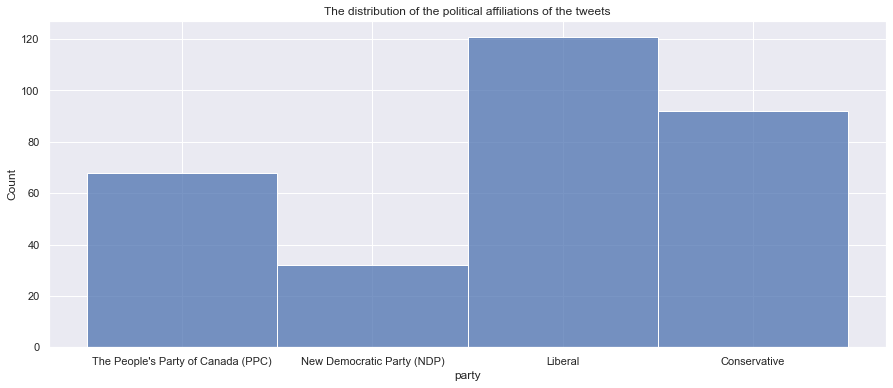

In [ ]:
# Plot the histogram of the political affiliations of the tweets
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,6))
sns.histplot(election_party['party'])
plt.title('The distribution of the political affiliations of the tweets')

# Table of the distribution of the political affiliations of the tweets
party_tab = pd.DataFrame({'Party': election_party['party'].value_counts().index, 'Count': election_party['party'].value_counts().values})
party_tab.style.set_table_attributes("style='display:inline'").set_caption('The distribution table of the political affiliations of the tweets')

After I determined the party for the election data, 313 tweets were assigned parties. The number of tweets for each party and its distribution is shown above. We can see that the tweets that support the Liberal party are the most, followed by the Conservative party and The People's Party of Canada (PPC). The tweets that support the New Democratic Party (NDP) are the least, with 32 out of 313 tweets. Also, most of the tweets' parties were classified as 'NaN'. It is because those tweets may not mention the 4 parties in the hashtags or mentions. Some tweets may support other parties classified as 'NaN' here; some are not relevant to the election, some only show the parties they don't support, and some may support their parties without mentioning the keywords I assigned. These all will make the party become 'NaN'. Overall, the liberal party and conservative party are the two most popular parties in the election data.

## Visualization

### WordCloud

Wordcloud is a graphical representation of word frequency, giving greater importance to words that appear more frequently in the text. The larger the word in the visualization, the more common that word is in the document.

#### WordCloud for the texts of generic tweets

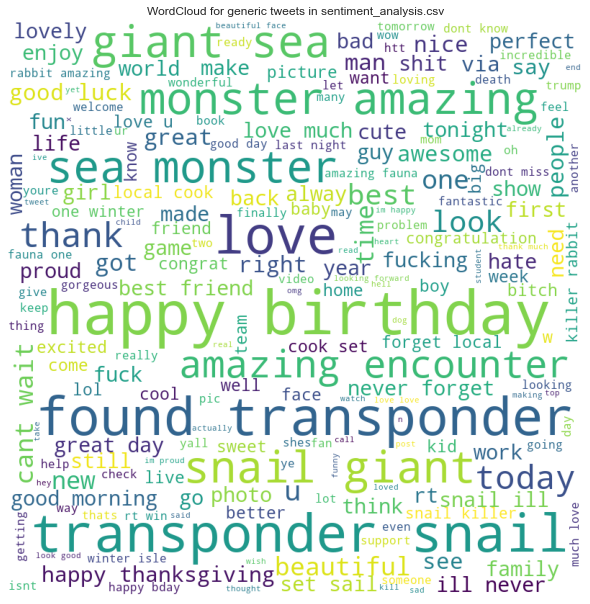

In [ ]:
# WordCloud for the texts of generic tweets in sentiment_analysis.csv

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS

# Generate the seires of texts of tweets
sen_texts = []
for i in range(sentiment_copy['text'].shape[0]):
    sen_texts.append(sentiment_copy['text'].loc[i])
string_sen = pd.Series(sen_texts).str.cat(sep=' ')

wordcloud_sen = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(string_sen)
 
# plot the WordCloud image for texts of generic tweets in sentiment_analysis.csv                
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_sen)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud for generic tweets in sentiment_analysis.csv')
plt.show()

We can see that, in generic tweets, the most frequent words are "happy birthday', "found transponder", "transponder".

#### WordCloud for the texts of 2021 Canadian election tweets

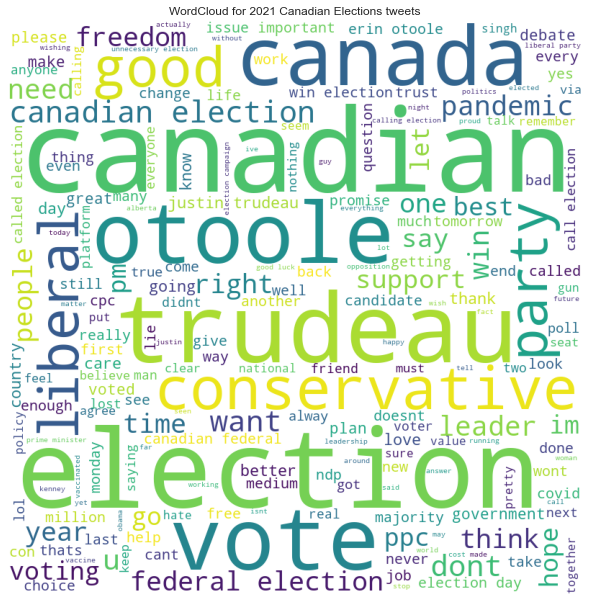

In [ ]:
# WordCloud for 2021 Canadian Elections tweets texts

# Apply the cleaning function to the 2021 Canadian Elections tweets and give the cleaned data
election_copy['text'] = election_copy['text'].apply(textcleaning)

# Generate the seires of texts of tweets
elec_texts = []
for i in range(1002):
    elec_texts.append(election_copy['text'].loc[i])
string_elec = pd.Series(elec_texts).str.cat(sep=' ')

wordcloud_elec = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(string_elec)

# plot the WordCloud image for 2021 Canadian Elections tweets texts      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_elec)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('WordCloud for 2021 Canadian Elections tweets')
plt.show()

From the wordcloud of Canadian Election data, we can see that the most frequent words are: "canadian", "election", "trudeau", "otoole", "vote" and "conservative". It shows that there are a large number of tweets talking about the Canadian election, liberal party and conservative party.  

### Sentiment visualization

#### Sentiment visualization for generic tweets

Text(0.5, 1.0, 'The distribution of sentiment of generic tweets')

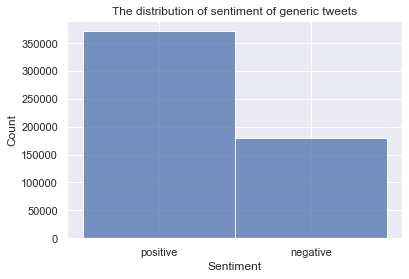

In [ ]:
# Plot the histogram of sentiment of generic tweets

# Transfrom the label column for generic tweets data into column sentiment with negative sentiment = 0, positive sentiment = 1
sen_list = []
for i in range(sentiment_copy['label'].shape[0]):
  if sentiment_copy['label'][i] == 1:
    sen_list.append('positive')
  elif sentiment_copy['label'][i] == 0:
    sen_list.append('negative')
sen_df = pd.DataFrame(sen_list)

# Histogram of sentiment of generic tweets
sns.histplot(sen_df[0])
plt.xlabel('Sentiment')
plt.title('The distribution of sentiment of generic tweets')

#### Sentiment visualization for political affiliations of the tweets

Text(0.5, 1.0, 'The distribution of sentiment of generic tweets')

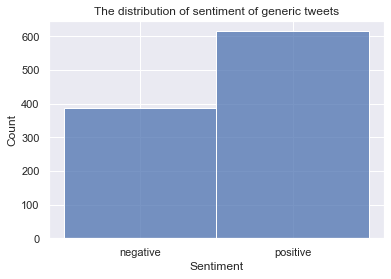

In [ ]:
# Plot the histogram of sentiment of the political affiliations of the tweets
sns.histplot(election_copy['sentiment'])
plt.xlabel('Sentiment')
plt.title('The distribution of sentiment of generic tweets')

By plotting the distribution of sentiment of the two data set, we can see that there are two kinds of sentiments: positive and negative. The number of positive sentiments is higher than the number of negative sentiments for both data sets.

### Pie chart for the negative reason for election data with negative sentiment

In [ ]:
# Extract the election data with negative sentiment
elec_n = election_copy[election_copy['sentiment'] == 'negative']
# Find negative reasons
neg_reason = [word for word in Counter(elec_n['negative_reason']).keys()]
# Compute the count for each reason
neg_count = [Counter(elec_n['negative_reason'])[word] for word in Counter(elec_n['negative_reason']).keys()]

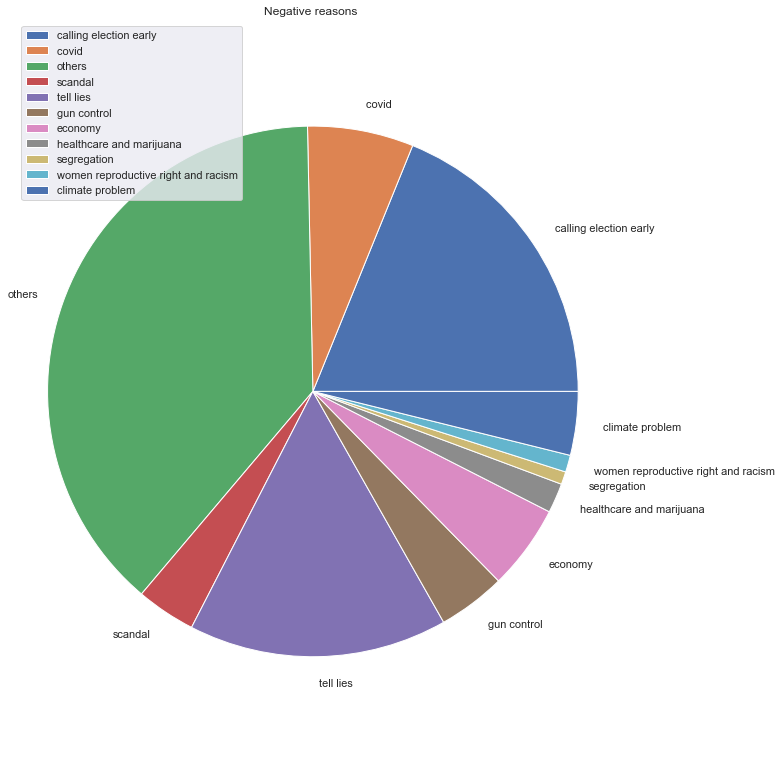

In [ ]:
# Plot the pie chart for visualizing the negative reason for negative sentiment of election data
fig, ax = plt.subplots(figsize=[11, 11])
ax.pie(neg_count, labels = neg_reason)
ax.axis('equal')  
ax.set_title('Negative reasons')
plt.legend(loc="upper left")
fig.tight_layout()
plt.show()

By the pie chart I plotted above, except for other reasons, we can see calling election early and tell lies occupied a large proportion of the negative data, which shows that a large proportion of tweets with negative sentiments are due to these two reasons. Also, covid, climate problem and economy are primary reasons for negative sentiments. Segregation and women reproductive right and racism take the minor proportion in negative reasons. We also concluded that the negative reasons are unbalanced. This information may be helpful in the model implementations we will conduct later. 

# 3. Model preparation

In this section, I used two types of methods to extract features from the text of the data set, bag of words and TF-IDF, to implement the model. In this analysis, the data will use 7 classification algorithms to classify the sentiment value: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost.

## Bag of Words

The bag-of-words model is a method for extracting features from the text for different machine learning algorithms. A bag of words is a representation of text that describes the words that appear in a document. It only involves two things: a vocabulary of known words and a measure of the presence of a known word. The model is only concerned with whether the words appear in the document, not where the words are.

I used this method to extract the features from the text of the tweets of generic tweets and split them randomly into training data (70%) and test data (30%).

In [ ]:
# Use bag of words to vectorize data
vectorizer_bow = CountVectorizer()
array_bow = vectorizer_bow.fit_transform(sentiment_copy['text'])
array_bow

<550391x124020 sparse matrix of type '<class 'numpy.int64'>'
	with 3466593 stored elements in Compressed Sparse Row format>

In [ ]:
# Exstract target data
sen_target = sentiment_copy.iloc[:, -1]

# Split the data of bag of works in training and testing dataset
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(array_bow, sen_target, train_size=0.7, random_state = 0, stratify = sen_target)

## TF-IDF

TF-IDF is another method for extracting features. TF-IDF stands for term frequency-inverse document frequency. It is a statistical measure used to assess the importance of a word to a document in a collection. I used this method to extract the text features of generic tweets and split them into training and test data in the same proportion. Then, the data is ready to fit models.

In [ ]:
# Use TF-IDF to vectorize data
vectorizer_tfidf = TfidfVectorizer()
array_tfidf = vectorizer_tfidf.fit_transform(sentiment_copy['text'])
array_tfidf

<550391x124020 sparse matrix of type '<class 'numpy.float64'>'
	with 3466593 stored elements in Compressed Sparse Row format>

In [ ]:
# Split the data of TF-IDF in training and testing dataset
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(array_tfidf, sen_target, train_size=0.7, random_state = 0, stratify = sen_target)

# 4. Model implementation and tuning

## a)

In this section, I tried to use both feature types to train models on the training data from generic tweets and apply the model to the test data to obtain an accuracy value. I used seven classification algorithms to fit the data.

The classification algorithms include:

Logistic Regression, K-NN, Naive Bayes, SVM, Decision Trees, Random Forest, XGBoost

I first used the gridsearch for the two methods of each model and found the optimal hyperparameter, fit the training data to the optimal model of each algorithm, and applied the optimal model to the test data to obtain its accuracy.

The tuning process for each model and the corresponding accuracy is shown below.

#### Hyperparameters tuning for Logistic Regression


##### Bag of words

In [ ]:
para_lr = {'C':[0.01, 0.1, 1, 10], 'solver':['newton-cg','lbfgs', 'liblinear']}

tune_search = TuneGridSearchCV(
    LogisticRegression(max_iter = 1000),
    para_lr, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_ * 100, 2)))
print('The best parameter:\n', tune_search.best_params_)

/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:369: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "


The best cross-validation score: 97.283%
The best parameter:
 {'C': 1, 'solver': 'liblinear'}


In [ ]:
# Fit the best model with optimal hyperparameters for Logistic Regression
best_ir_bow = LogisticRegression(C = 1, solver = 'liblinear')
best_ir_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for Logistic Regression
train_pred = best_ir_bow.predict(X_train_bow)
train_acc_ir_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for Logistic Regression
test_pred = best_ir_bow.predict(X_test_bow)
test_acc_ir_b = accuracy_score(y_test_bow, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_ir_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_ir_bow = precision_score(y_test_bow, test_pred)

print("Model Name: ", 'Logistic Regression with bag of words')
print("Training accuracy: {}".format(train_acc_ir_b))
print("Test accuracy: {}".format(test_acc_ir_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_ir_bow)
print("Precision score for test data: {}".format(pre_ir_bow))

Model Name:  Logistic Regression with bag of words
Training accuracy: 0.9819400788531768
Test accuracy: 0.9740851996753837
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51715   2000]
 [  2279 109124]]
Precision score for test data: 0.98200208775782


##### TF-IDF

In [ ]:
para_lr = {'C':[0.01, 0.1, 1, 10], 'solver':['newton-cg','lbfgs', 'liblinear']}

tune_search = TuneGridSearchCV(
    LogisticRegression(max_iter = 1000),
    para_lr, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 2)))
print('The best parameter:\n', tune_search.best_params_)

/usr/local/lib/python3.7/dist-packages/ray/tune/tune.py:369: UserWarning: The `loggers` argument is deprecated. Please pass the respective `LoggerCallback` classes to the `callbacks` argument instead. See https://docs.ray.io/en/latest/tune/api_docs/logging.html
  "The `loggers` argument is deprecated. Please pass the respective "


The best cross-validation score: 97.383%
The best parameter:
 {'C': 10, 'solver': 'liblinear'}


In [ ]:
# Fit the best model with optimal hyperparameters for Logistic Regression
best_ir_tfidf = LogisticRegression(C = 10, solver = 'liblinear')
best_ir_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for Logistic Regression
train_pred = best_ir_tfidf.predict(X_train_tfidf)
train_acc_ir_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for Logistic Regression
test_pred = best_ir_tfidf.predict(X_test_tfidf)
test_acc_ir_t = accuracy_score(y_test_tfidf, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_ir_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_ir_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'Logistic Regression with TF-IDF')
print("Training accuracy: {}".format(train_acc_ir_t))
print("Test accuracy: {}".format(test_acc_ir_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_ir_t)
print("Precision score for test data: {}".format(pre_ir_t))

Model Name:  Logistic Regression with TF-IDF
Training accuracy: 0.9867911844328567
Test accuracy: 0.9747392773652782
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51707   2008]
 [  2163 109240]]
Precision score for test data: 0.981950237307637


#### Hyperparameters tuning for K Nearest Neighbors

##### Bag of words

In [ ]:
para_knn = {'n_neighbors':[10, 100, 500]}

tune_search = TuneGridSearchCV(
    KNeighborsClassifier(),
    para_knn, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 2)))
print('The best parameter:\n', tune_search.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
The best cross-validation score: 92.333%
The best parameter:
 {'n_neighbors': 10}


In [ ]:
# Fit the best model with optimal hyperparameters for K Nearest Neighbors
best_knn_bow = KNeighborsClassifier(n_neighbors = 10)
best_knn_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for K Nearest Neighbors
train_pred = best_knn_bow.predict(X_train_bow)
train_acc_knn_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for K Nearest Neighbors
test_pred = best_knn_bow.predict(X_test_bow)
test_acc_knn_b = accuracy_score(y_test_bow, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_knn_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_knn_bow = precision_score(y_test_bow, test_pred)

print("Model Name: ", 'K Nearest Neighbors with bag of words')
print("Training accuracy: {}".format(train_acc_knn_b))
print("Test accuracy: {}".format(test_acc_knn_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_knn_bow)
print("Precision score for test data: {}".format(pre_knn_bow))

Model Name:  K Nearest Neighbors with bag of words
Training accuracy: 0.9403929161918951
Test accuracy: 0.9257561259220679
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 46896   6819]
 [  5440 105963]]
Precision score for test data: 0.9395382241847103


##### TF-IDF

In [ ]:
para_knn = {'n_neighbors':[10, 100, 500]}

tune_search = TuneGridSearchCV(
    KNeighborsClassifier(),
    para_knn, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 2)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 86.442%
The best parameter:
 {'n_neighbors': 500}


In [ ]:
# Fit the best model with optimal hyperparameters for K Nearest Neighbors
best_knn_tfidf = KNeighborsClassifier(n_neighbors = 500)
best_knn_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for K Nearest Neighbors
train_pred = best_knn_tfidf.predict(X_train_tfidf)
train_acc_knn_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for K Nearest Neighbors
test_pred = best_knn_tfidf.predict(X_test_tfidf)
test_acc_knn_t = accuracy_score(y_test_tfidf, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_knn_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_knn_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'K Nearest Neighbors with TF-IDF')
print("Training accuracy: {}".format(train_acc_knn_t))
print("Test accuracy: {}".format(test_acc_knn_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_knn_t)
print("Precision score for test data: {}".format(pre_knn_t))

Model Name:  K Nearest Neighbors with TF-IDF
Training accuracy: 0.8697936268568003
Test accuracy: 0.8690451676982521
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 33702  20013]
 [  1610 109793]]
Precision score for test data: 0.845823767776528


#### Hyperparameters tuning for Naive Bayes

##### Bag of words

In [ ]:
import warnings
warnings.filterwarnings('ignore')

para_nb = {'alpha':[0.01, 0.1, 1, 5, 10, 100]}

tune_search = TuneGridSearchCV(
    MultinomialNB(),
    para_nb, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100,2)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 95.39%
The best parameter:
 {'alpha': 1}


In [ ]:
# Fit the best model with optimal hyperparameters for Naive Bayes
best_nb_bow = MultinomialNB(alpha = 1)
best_nb_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for Naive Bayes
train_pred = best_nb_bow.predict(X_train_bow)
train_acc_nb_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for Naive Bayes
test_pred = best_nb_bow.predict(X_test_bow)
test_acc_nb_b = accuracy_score(y_test_bow, test_pred)  

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_nb_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_nb_bow = precision_score(y_test_bow, test_pred)


print("Model Name: ", 'Naive Bayes with bag of words')
print("Training accuracy: {}".format(train_acc_nb_b))
print("Test accuracy: {}".format(test_acc_nb_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_nb_bow)
print("Precision score for test data: {}".format(pre_nb_bow))

Model Name:  Naive Bayes with bag of words
Training accuracy: 0.9622553358268033
Test accuracy: 0.9534878087186134
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 49335   4380]
 [  3300 108103]]
Precision score for test data: 0.9610607825182472


##### TF-IDF

In [ ]:
para_nb = {'alpha':[0.01, 0.1, 1, 5, 10, 100]}

tune_search = TuneGridSearchCV(
    MultinomialNB(),
    para_nb, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100,2)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 93.06%
The best parameter:
 {'alpha': 0.1}


In [ ]:
# Fit the best model with optimal hyperparameters for Naive Bayes
best_nb_tfidf = MultinomialNB(alpha = 0.1)
best_nb_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for Naive Bayes
train_pred = best_nb_tfidf.predict(X_train_tfidf)
train_acc_nb_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for Naive Bayes
test_pred = best_nb_tfidf.predict(X_test_tfidf)
test_acc_nb_t = accuracy_score(y_test_tfidf, test_pred)   

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_nb_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_nb_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'Naive Bayes with bag of words')
print("Training accuracy: {}".format(train_acc_nb_t))
print("Test accuracy: {}".format(test_acc_nb_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_nb_t)
print("Precision score for test data: {}".format(pre_nb_t))

Model Name:  Naive Bayes with bag of words
Training accuracy: 0.9542428355996917
Test accuracy: 0.9303770636756744
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 45802   7913]
 [  3583 107820]]
Precision score for test data: 0.9316271072209309


#### Hyperparameters tuning for Support Vector Machine

##### Bag of words

In [ ]:
para_svm = {'C':[0.01, 0.1, 1, 10]}

tune_search = TuneGridSearchCV(
    svm.LinearSVC(max_iter = 10000),
    para_svm, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)
 
print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 2)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 97.31%
The best parameter:
 {'C': 0.1}


In [ ]:
# Fit the best model with optimal hyperparameters for Support Vector Machine
best_svm_bow = svm.LinearSVC(C = 0.1, max_iter = 10000)
best_svm_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for Support Vector Machine
train_pred = best_svm_bow.predict(X_train_bow)
train_acc_svm_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for Support Vector Machine
test_pred = best_svm_bow.predict(X_test_bow)
test_acc_svm_b = accuracy_score(y_test_bow, test_pred)   

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_svm_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_svm_bow = precision_score(y_test_bow, test_pred)


print("Model Name: ", 'Support Vector Machine with bag of words')
print("Training accuracy: {}".format(train_acc_svm_b))
print("Test accuracy: {}".format(test_acc_svm_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_svm_bow)
print("Precision score for test data: {}".format(pre_svm_bow))

Model Name:  Support Vector Machine with bag of words
Training accuracy: 0.9827031741129018
Test accuracy: 0.9741033685001029
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51777   1938]
 [  2338 109065]]
Precision score for test data: 0.9825410124050701


##### TF-IDF

In [ ]:
para_svm = {'C':[0.01, 0.1, 1, 10]}

tune_search = TuneGridSearchCV(
    svm.LinearSVC(max_iter = 10000),
    para_svm, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100,2)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 97.35%
The best parameter:
 {'C': 1}


In [ ]:
# Fit the best model with optimal hyperparameters for Support Vector Machine
best_svm_tfidf = svm.LinearSVC(C = 1, max_iter = 10000)
best_svm_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for Support Vector Machine
train_pred = best_svm_tfidf.predict(X_train_tfidf)
train_acc_svm_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for Support Vector Machine
test_pred = best_svm_tfidf.predict(X_test_tfidf)
test_acc_svm_t = accuracy_score(y_test_tfidf, test_pred) 

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_svm_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_svm_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'Support Vector Machine with bag of words')
print("Training accuracy: {}".format(train_acc_svm_t))
print("Test accuracy: {}".format(test_acc_svm_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_svm_t)
print("Precision score for test data: {}".format(pre_svm_t))

Model Name:  Support Vector Machine with bag of words
Training accuracy: 0.9870922696373741
Test accuracy: 0.9744425198948631
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51732   1983]
 [  2237 109166]]
Precision score for test data: 0.9821590837524404


#### Hyperparameters tuning for Decision Tree

##### Bag of words

In [ ]:
para_dt = {'max_depth':[1, 10, 50, 100], 'min_samples_split':[2, 5, 10]}

tune_search = TuneGridSearchCV(
    DecisionTreeClassifier(),
    para_dt, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 92.308%
The best parameter:
 {'max_depth': 100, 'min_samples_split': 2}


In [ ]:
# Fit the best model with optimal hyperparameters for Decision Tree
best_dt_bow = DecisionTreeClassifier(max_depth = 100, min_samples_split = 2)
best_dt_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for Decision Tree
train_pred = best_dt_bow.predict(X_train_bow)
train_acc_dt_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for Decision Tree
test_pred = best_dt_bow.predict(X_test_bow)
test_acc_dt_b = accuracy_score(y_test_bow, test_pred)  

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_dt_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_dt_bow = precision_score(y_test_bow, test_pred)


print("Model Name: ", 'Decision Tree with bag of words')
print("Training accuracy: {}".format(train_acc_dt_b))
print("Test accuracy: {}".format(test_acc_dt_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_dt_bow)
print("Precision score for test data: {}".format(pre_dt_bow))

Model Name:  Decision Tree with bag of words
Training accuracy: 0.9371173168117153
Test accuracy: 0.924139100522051
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51240   2475]
 [ 10051 101352]]
Precision score for test data: 0.976162269929787


##### TF-IDF

In [ ]:
para_dt = {'max_depth':[1, 10, 50, 100], 'min_samples_split':[2, 5, 10]}

tune_search = TuneGridSearchCV(
    DecisionTreeClassifier(),
    para_dt, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 92.147%
The best parameter:
 {'max_depth': 100, 'min_samples_split': 2}


In [ ]:
# Fit the best model with optimal hyperparameters for Decision Tree
best_dt_tfidf = DecisionTreeClassifier(max_depth = 100, min_samples_split = 2)
best_dt_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for Decision Tree
train_pred = best_dt_tfidf.predict(X_train_tfidf)
train_acc_dt_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for Decision Tree
test_pred = best_dt_tfidf.predict(X_test_tfidf)
test_acc_dt_t = accuracy_score(y_test_tfidf, test_pred)   

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_dt_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_dt_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'Decision Tree with bag of words')
print("Training accuracy: {}".format(train_acc_dt_t))
print("Test accuracy: {}".format(test_acc_dt_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_dt_t)
print("Precision score for test data: {}".format(pre_dt_t))

Model Name:  Decision Tree with bag of words
Training accuracy: 0.9382048573349288
Test accuracy: 0.9227037633692269
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51256   2459]
 [ 10304 101099]]
Precision score for test data: 0.9762548523532706


#### Hyperparameters tuning for Random Forest

##### Bag of words

In [ ]:
para_rf = {'max_depth':[1, 10, 100], 'min_samples_split':[2, 5, 10]}

tune_search = TuneGridSearchCV(
    RandomForestClassifier(),
    para_rf, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 80.153%
The best parameter:
 {'max_depth': 100, 'min_samples_split': 2}


In [ ]:
# Fit the best model with optimal hyperparameters for Random Forest
best_rf_bow = RandomForestClassifier(max_depth = 100, min_samples_split = 2)
best_rf_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for Random Forest
train_pred = best_rf_bow.predict(X_train_bow)
train_acc_rf_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for Random Forest
test_pred = best_rf_bow.predict(X_test_bow)
test_acc_rf_b = accuracy_score(y_test_bow, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_rf_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_rf_bow = precision_score(y_test_bow, test_pred)

print("Model Name: ", 'Random Forest with bag of words')
print("Training accuracy: {}".format(train_acc_rf_b))
print("Test accuracy: {}".format(test_acc_rf_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_rf_bow)
print("Precision score for test data: {}".format(pre_rf_bow))

Model Name:  Random Forest with bag of words
Training accuracy: 0.8108821536936146
Test accuracy: 0.7963577562712727
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 20263  33452]
 [   173 111230]]
Precision score for test data: 0.7687894831423397


##### TF-IDF

In [ ]:
para_rf = {'max_depth':[1, 10, 100], 'min_samples_split':[2, 5, 10]}

tune_search = TuneGridSearchCV(
    RandomForestClassifier(max_depth = 100, min_samples_split = 2),
    para_rf, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

In [ ]:
# Fit the best model with optimal hyperparameters for Random Forest
best_rf_tfidf = RandomForestClassifier(max_depth = 100, min_samples_split = 2)
best_rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for Random Forest
train_pred = best_rf_tfidf.predict(X_train_tfidf)
train_acc_rf_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for Random Forest
test_pred = best_rf_tfidf.predict(X_test_tfidf)
test_acc_rf_t = accuracy_score(y_test_tfidf, test_pred)  

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_rf_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_rf_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'Random Forest with bag of words')
print("Training accuracy: {}".format(train_acc_rf_t))
print("Test accuracy: {}".format(test_acc_rf_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_rf_t)
print("Precision score for test data: {}".format(pre_rf_t))

Model Name:  Random Forest with bag of words
Training accuracy: 0.8130754036747968
Test accuracy: 0.7981080197192311
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 20591  33124]
 [   212 111191]]
Precision score for test data: 0.7704743096698194


#### Hyperparameters tuning for XGBoost

##### Bag of words

In [ ]:
from xgboost import XGBClassifier

para_xb = {'max_depth':[1, 5, 10, 20], 'subsample':[0.5, 1]}

tune_search = TuneGridSearchCV(
    XGBClassifier(),
    para_xb, cv = 10, n_jobs = -1)
tune_search.fit(X_train_bow, y_train_bow)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 92.98%
The best parameter:
 {'max_depth': 20, 'subsample': 1}


In [ ]:
# Fit the best model with optimal hyperparameters for XGBoost
best_xb_bow = XGBClassifier(max_depth = 20, subsample = 1)
best_xb_bow.fit(X_train_bow, y_train_bow)

# The training accuracy for XGBoost
train_pred = best_xb_bow.predict(X_train_bow)
train_acc_xb_b = accuracy_score(y_train_bow, train_pred)

# The testing accuracy for XGBoost
test_pred = best_xb_bow.predict(X_test_bow)
test_acc_xb_b = accuracy_score(y_test_bow, test_pred)  

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_xb_bow = confusion_matrix(y_test_bow, test_pred, labels=[0, 1])
pre_xb_bow = precision_score(y_test_bow, test_pred)

print("Model Name: ", 'XGBoost with bag of words')
print("Training accuracy: {}".format(train_acc_xb_b))
print("Test accuracy: {}".format(test_acc_xb_b))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_xb_bow)
print("Precision score for test data: {}".format(pre_xb_bow))

[18:44:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name:  XGBoost with bag of words
Training accuracy: 0.9595351867377159
Test accuracy: 0.9554560980632033
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51596   2119]
 [  5236 106167]]
Precision score for test data: 0.9804314500489445


##### TF-IDF

In [ ]:
para_xb = {'max_depth':[1, 5, 10, 20], 'subsample':[0.5, 1]}

tune_search = TuneGridSearchCV(
    XGBClassifier(),
    para_xb, cv = 10, n_jobs = -1)
tune_search.fit(X_train_tfidf, y_train_tfidf)

print('The best cross-validation score: {}%'.format(round(tune_search.best_score_*100, 3)))
print('The best parameter:\n', tune_search.best_params_)

The best cross-validation score: 93.003%
The best parameter:
 {'max_depth': 20, 'subsample': 1}


In [ ]:
# Fit the best model with optimal hyperparameters for XGBoost
best_xb_tfidf = XGBClassifier(max_depth = 20, subsample = 1)
best_xb_tfidf.fit(X_train_tfidf, y_train_tfidf)

# The training accuracy for XGBoost
train_pred = best_xb_tfidf.predict(X_train_tfidf)
train_acc_xb_t = accuracy_score(y_train_tfidf, train_pred)

# The testing accuracy for XGBoost
test_pred = best_xb_tfidf.predict(X_test_tfidf)
test_acc_xb_t = accuracy_score(y_test_tfidf, test_pred)   

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_xb_t = confusion_matrix(y_test_tfidf, test_pred, labels=[0, 1])
pre_xb_t = precision_score(y_test_tfidf, test_pred)

print("Model Name: ", 'XGBoost with bag of words')
print("Training accuracy: {}".format(train_acc_xb_t))
print("Test accuracy: {}".format(test_acc_xb_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score:")
print ("Confusion matrix for test data: \n", conf_matrix_xb_t)
print("Precision score for test data: {}".format(pre_xb_t))

[18:44:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Name:  XGBoost with bag of words
Training accuracy: 0.9639190911379723
Test accuracy: 0.9553773664894197
Two other metrics used to evaluate the models: confusion matrix, precision score:
Confusion matrix for test data: 
 [[ 51531   2184]
 [  5184 106219]]
Precision score for test data: 0.9798529560990009


After tuning and fitting models, we got 14 training and testing accuracy, which is shown below.

In [ ]:
acc_dic = {'Algorithm': ['Logistic Regression', 'K-NN', 'Naive Bayes', 
           'SVM', 'Decision Trees', 'Random Forest', 'XGBoost'],
           'Traning accuracy for BOW': [0.9819400788531768, 0.9403929161918951,0.9622553358268033, 
                                        0.9827031741129018,0.9371173168117153,0.8108821536936146,0.9595351867377159],
           'Testing accuracy for BOW': [0.9740851996753837,0.9257561259220679,0.9534878087186134,0.9741033685001029,
                                        0.924139100522051,0.7963577562712727,0.9554560980632033],
           'Traning accuracy for TF-IDF': [0.9867911844328567,0.8697936268568003,0.9542428355996917,0.9870922696373741,
                                           0.9382048573349288,0.8130754036747968,0.9639190911379723],
           'Testing accuracy for TF-IDF': [0.9747392773652782,0.8690451676982521,0.9303770636756744,0.9744425198948631,
                                           0.9227037633692269,0.7981080197192311,0.9553773664894197]}
acc_df = pd.DataFrame(acc_dic)
acc_df

,Algorithm,Traning accuracy for BOW,Testing accuracy for BOW,Traning accuracy for TF-IDF,Testing accuracy for TF-IDF
0,Logistic Regression,0.981940,0.974085,0.986791,0.974739
1,K-NN,0.940393,0.925756,0.869794,0.869045
2,Naive Bayes,0.962255,0.953488,0.954243,0.930377
3,SVM,0.982703,0.974103,0.987092,0.974443
4,Decision Trees,0.937117,0.924139,0.938205,0.922704
5,Random Forest,0.810882,0.796358,0.813075,0.798108
6,XGBoost,0.959535,0.955456,0.963919,0.955377


We can see that the testing accuracy of logistic regression with TF-IDF is the highest with hyperparameter C = 10 and solver = 'liblinear'. I will use this model as my best performance model and evaluate the trained model on the Canadian Elections data.

To evaluate the trained model on the election data, firstly, I encoded the sentiment column of the election data to let 0 = negative and 1 = positive. Also, I used the TF-IDF method to extract the election data features and split them into training data (70%) and testing data (30%). Then, the data is ready to be put into the model.

In [ ]:
# Encode column sentiment with 0 = negative sentiment, 1 = positive sentiment
le = LabelEncoder()
election_copy['sentiment'] = le.fit_transform(election_copy['sentiment'].values.tolist())

In [ ]:
# Vectorize text data using previous TF-IDF vectorizer
elec_tfidf = vectorizer_tfidf.transform(election_copy['text'])
elec_tfidf

<1002x124020 sparse matrix of type '<class 'numpy.float64'>'
	with 13832 stored elements in Compressed Sparse Row format>

In [ ]:
# Split the election data in training and testing dataset in TF-IDF
X_train_elec, X_test_elec, y_train_elec, y_test_elec = train_test_split(elec_tfidf, election_copy['sentiment'],
                                                                        train_size=0.7,random_state = 1,
                                                                        stratify = election_copy['sentiment'])

In [ ]:
# The training accuracy for trained Logistic Regression
train_pred = best_ir_tfidf.predict(X_train_elec)
train_acc_t = accuracy_score(y_train_elec, train_pred)

# The testing accuracy for trained Logistic Regression
test_pred = best_ir_tfidf.predict(X_test_elec)
test_acc_t = accuracy_score(y_test_elec, test_pred)

# Two other metrics used to evaluate the models: confusion matrix, precision score
conf_matrix_t = confusion_matrix(y_test_elec, test_pred, labels=[0, 1])
pre_t = precision_score(y_test_elec, test_pred)

print("Model Name: ", 'Logistic Regression with TF-IDF')
print("Training accuracy: {}".format(train_acc_t))
print("Test accuracy: {}".format(test_acc_t))
print("Two other metrics used to evaluate the models: confusion matrix, precision score")
print ("Confusion matrix for test data: \n", conf_matrix_t)
print("Precision score for test data: {}".format(pre_t))

Model Name:  Logistic Regression with TF-IDF
Training accuracy: 0.6975748930099858
Test accuracy: 0.6710963455149501
Two other metrics used to evaluate the models: confusion matrix, precision score
Confusion matrix for test data: 
 [[105  11]
 [ 88  97]]
Precision score for test data: 0.8981481481481481


By applying the trained model to the election data, we got the training accuracy of around 0.698 and the testing accuracy of about 0.671. The two accuracies are pretty considerable. Also, the two other metrics used to evaluate the models here are the confusion matrix and precision score.

Confusion matrix is a performance measure for machine learning classification problems, where the output can be two or more categories. It is a table with 4 different combinations of predicted and actual values: True Positive, True Negative, False Positive and False Negative, and it makes it easy to see if mislabeling has occurred and if the predictions are more accurate.

Precesion score is the True Positive divided by the total number of True Positive and False Positive, which describes how many are actually positive from all the classes we have predicted as positive. The higher the precision score is, the better the model is. Based on the precision score, the trained model is not bad.

Based on our metrics, the NLP analytics based on tweets is useful for political parties during election campaigns. The accuracies and precision scores are relatively high by the trained model. To improve the accuracy of this model, we can gather more data on tweets that are relevant to the election. We only got around 1000 election tweets, which is a really small data set. The more data the training model gets, the more data the model learns, and the more cases it could correctly classify.

### Visualization of the sentiment prediction results and the true sentiment for each of the 4 parties

In [ ]:
# Prepare a dataframe with columns party, sentiment and its prediction for visulaization
elec_party = election_withparty['party'].loc[y_test_elec.keys()]
elec_test = pd.DataFrame(elec_party)
elec_test['sentiment'] = y_test_elec
elec_test['prediction'] = test_pred
elec_test

,party,sentiment,prediction
643,NaN,1,1
781,Conservative,1,0
734,NaN,1,0
131,Liberal,1,1
162,NaN,1,1
...,...,...,...
542,NaN,1,0
612,NaN,1,1
697,Conservative,1,0
870,NaN,0,0


#### Sentiment prediction results and the true sentiment for Liberal

<AxesSubplot:xlabel='prediction', ylabel='count'>

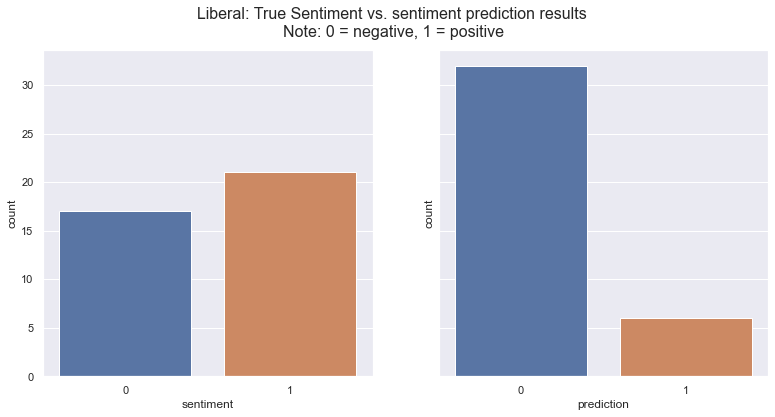

In [ ]:
# Sentiment prediction results and the true sentiment for Liberal
elec_lib = elec_test[elec_test['party'] == 'Liberal']
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 6))
fig.suptitle('Liberal: True Sentiment vs. sentiment prediction results \nNote: 0 = negative, 1 = positive', fontsize = 16)

sns.countplot(x = 'sentiment', data = elec_lib, ax = ax1)
sns.countplot(x = 'prediction', data = elec_lib, ax = ax2)

The plot above shows the distribution of true sentiments and sentiment prediction results for the liberal party. Based on the true sentiments, we can see that people with positive sentiments are higher than people with negative sentiments for the liberal party, which means that over half of people positively view liberals. However, we can see that the predicted sentiments got many negative sentiments, which means that the main prediction error is from the false negative. The model predicted the tweets with negative sentiments were actually with positive sentiments. Therefore, the NLP analytics based on generic tweets may underestimate the tweets with positive sentiments. 

#### Sentiment prediction results and the true sentiment for Conservative

<AxesSubplot:xlabel='prediction', ylabel='count'>

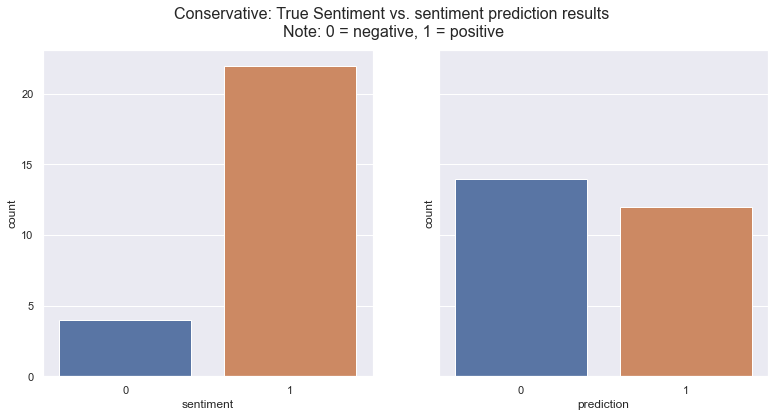

In [ ]:
# Sentiment prediction results and the true sentiment for Conservative
elec_con = elec_test[elec_test['party'] == 'Conservative']
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 6))
fig.suptitle('Conservative: True Sentiment vs. sentiment prediction results \nNote: 0 = negative, 1 = positive', fontsize = 16)

sns.countplot(x = 'sentiment', data = elec_con, ax = ax1)
sns.countplot(x = 'prediction', data = elec_con, ax = ax2)

For the plot of true sentiments and its prediction for the conservative party, we can see that the number of positive sentiments is much more than the number of negative sentiments, which shows that people usually have positive sentiments on the conservative party. The prediction model predicted a similar number of both sentiments. The main reason caused this result may be false negative, which means that the model predicts the tweets with positive sentiments as negative sentiments.

#### Sentiment prediction results and the true sentiment for The People's Party of Canada (PPC)

<AxesSubplot:xlabel='prediction', ylabel='count'>

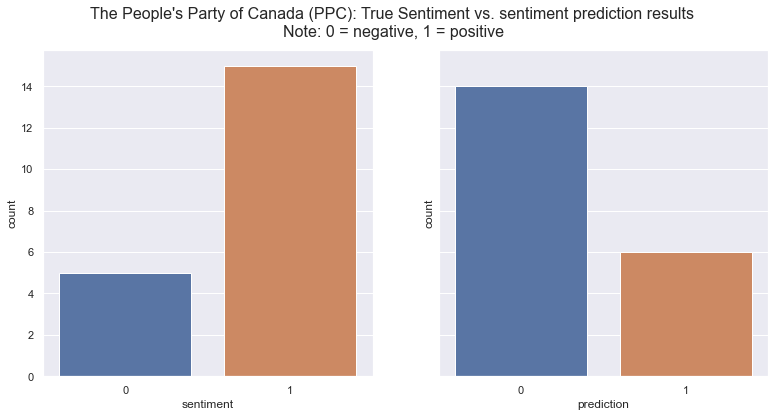

In [ ]:
# Sentiment prediction results and the true sentiment for The People's Party of Canada (PPC)
elec_ppc = elec_test[elec_test['party'] == "The People's Party of Canada (PPC)"]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 6))
fig.suptitle("The People's Party of Canada (PPC): True Sentiment vs. sentiment prediction results \nNote: 0 = negative, 1 = positive", fontsize = 16)

sns.countplot(x = 'sentiment', data = elec_ppc, ax = ax1)
sns.countplot(x = 'prediction', data = elec_ppc, ax = ax2)

For PPC, similar to the conservative party, we can see that the number of positive sentiments is higher than the number of negative sentiments in true sentiments, which shows that more people have a positive attitude toward PPC. However, the trained model predicted a higher number of negative sentiments, which overestimated the negative sentiments.

#### Sentiment prediction results and the true sentiment for New Democratic Party (NDP)

<AxesSubplot:xlabel='prediction', ylabel='count'>

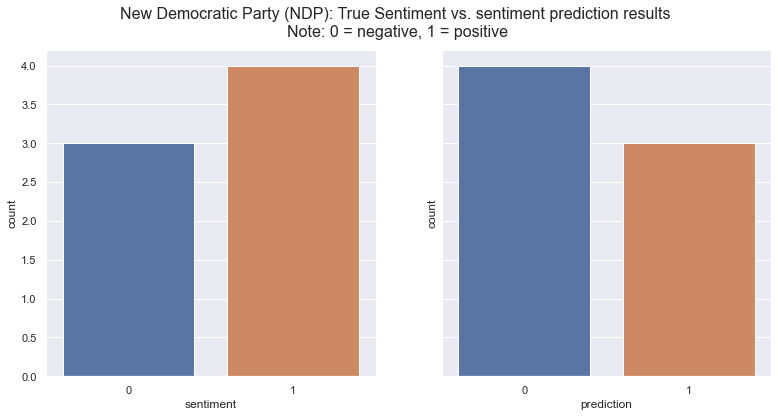

In [ ]:
# Sentiment prediction results and the true sentiment for New Democratic Party (NDP)
elec_ndp = elec_test[elec_test['party'] == "New Democratic Party (NDP)"]
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13, 6))
fig.suptitle("New Democratic Party (NDP): True Sentiment vs. sentiment prediction results \nNote: 0 = negative, 1 = positive", fontsize = 16)

sns.countplot(x = 'sentiment', data = elec_ndp, ax = ax1)
sns.countplot(x = 'prediction', data = elec_ndp, ax = ax2)

For NDP, the plot didn't show huge differences between true sentiments and prediction results. The difference between positive and negative sentiments is also not significant. We need more data to see people's views on NDP.

Overall, NLP is quite useful for political parties during election campaigns. Firstly, the test accuracy from the trained model by generic data is about 0.671, which is not bad. Secondly, the NLP analysis results could help the parties know the public reaction toward them. The parties also could make adjustments based on the previous sentiments and the sentiments predictions. Also, they can learn the negative reasons if they see the insight of the analysis, which could let the parties make adjustments towards the main negative reasons and win more votes.

### b) Impliment and tune model for negative Canadian elections tweets to predict the negative reason

For this part, I extracted the election data with negative sentiments to predict the negative reason. Firstly, since the negative reason has many classes, I combined similar reasons into four categories.

General Reason = 'scandal', 'tell lies'

Economic Reason = 'economy'

Political Reason = 'covid ','gun control', 'healthcare and marijuana', 'women reproductive right and racism', 'climate problem', 'segregation'

Others = 'others', 'calling election early'

I combined the reasons relevant with politics as political reasons, targeted to the candidates as general reasons, and relevant to economics as economic reason and combined the remaining as others.

Then, I used TF-IDF to vectorize data and split the data into training data (70%) and testing data (30%).

In [ ]:
# Extract election data with negative sentiments
election_negative = election_copy.drop(['hashtag', 'mentions', 'withparty'], axis=1)[election_copy['sentiment'] == 0]

# Extract the categories of negative reasons
pd.unique(election_nagative['negative_reason'].values.tolist())

array(['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation', 'women reproductive right and racism',
       'climate problem'], dtype=object)

In [ ]:
# Define new negative reason categories
general_reason = ['scandal', 'tell lies']
economic_reason = ['economy']
political_reason = ['covid ','gun control', 'healthcare and marijuana',
                    'women reproductive right and racism', 'climate problem',
                    'segregation']
others = ['others', 'calling election early']

# Assign new negative reason categories
for i in election_negative['negative_reason'].keys():
    if election_negative['negative_reason'][i] in general_reason:
        election_negative['negative_reason'][i] = 'General reasons'
    if election_negative['negative_reason'][i] in economic_reason:
        election_negative['negative_reason'][i] = 'Economic reasons'
    if election_negative['negative_reason'][i] in political_reason:
        election_negative['negative_reason'][i] = 'Political reasons'
    if election_negative['negative_reason'][i] in others:
        election_negative['negative_reason'][i] = 'Others'
            
election_negative

,text,sentiment,negative_reason,party
0,canadian election power grab pm trudeau yes ta...,0,Others,NaN
1,hope trudeau loses canadian election tomorrow ...,0,Political reasons,NaN
3,canadian friend never forget trudeau 2 year ma...,0,Others,NaN
5,vaccine gun key election otoole serious plan g...,0,Political reasons,NaN
6,im sorry moderator respond leadership candidat...,0,Others,NaN
...,...,...,...,...
997,absolutely horrible canada forthcoming electio...,0,Others,NaN
998,trudeau imposes gun control policy utterly fai...,0,Political reasons,NaN
999,canada election stolen thug uneducated goon de...,0,Others,NaN
1000,otoole amends platform gun control question re...,0,General reasons,Conservative


In [ ]:
# Use TF-IDF method to vectorize election negative data
vectorizer_tfidf = TfidfVectorizer()
array_neg = vectorizer_tfidf.fit_transform(election_negative['text'])

# Split the data of TF-IDF in training and testing dataset
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(array_neg, election_negative['negative_reason'], train_size=0.7, random_state = 0, stratify = election_negative['negative_reason'])

I chose the algorithm with the best performance with generic tweets data and logistic regression to train the negative data. Since the target variable negative reason has multiple classes, I used multiclass logistic regression to predict the negative reason. To get better accuracy, I tuned the hyperparameters, C and penalty, using gridsearch where:

C: Inverse to regularization strength. A value close to 1.0 indicates very little penalty, and a value close to 0 means a strong penalty.

Penalty: Regularization.

After tuning the hyperparameter, we got that when hyperparameter C = 21.544346900318846, penalty' = 'l2', the highest score. Thus, I used these hyperparameters and multiclass logistic regression to predict the reason for negative sentiment tweets and got a testing accuracy of 0.6410256410256411.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
# Set hyperparameters for logistic regression
c_rs = np.logspace(3, 0, num=10, endpoint = True)
p_rs = ["l1", "l2"]
param_grid =  [{'estimator__C': c_rs, 'estimator__penalty': p_rs}]

# Gridsearch to find the optimal hyperparameters
grid_search = GridSearchCV(
    OneVsRestClassifier(LogisticRegression(max_iter = 1000, multi_class = 'ovr')),
    param_grid, cv = 10, n_jobs = -1)
grid_search.fit(X_train_neg, y_train_neg)

print('The best cross-validation score: {}%'.format(round(grid_search.best_score_*100,2)))
print('The best parameter:\n', grid_search.best_params_)

The best cross-validation score: 60.0%
The best parameter:
 {'estimator__C': 21.544346900318846, 'estimator__penalty': 'l2'}


In [ ]:
# Fit the best model with optimal hyperparameters for multi-class logistic regression
best_neg = OneVsRestClassifier(LogisticRegression(C = 21.544346900318846, max_iter = 1000,  multi_class = 'ovr'))
best_neg.fit(X_train_neg, y_train_neg)

# testing accuracy
test_pred = best_neg.predict(X_test_neg)
test_acc_neg = accuracy_score(y_test_neg, test_pred)   

print("Model Name: ", 'Multi-class logistic regression')
print("Test accuracy: {}".format(test_acc_neg))

Model Name:  Multi-class logistic regression
Test accuracy: 0.6410256410256411


Based on the multiclass logistic regression model results for the negative reason prediction, we can see that even I reassigned the categories of negative reasons and used the model with optimal hyperparameters, the testing accuracy is not considerable. This may be because, firstly, the data size is too small. The election data only has around 1000 tweets, which is too little for fitting a multiclass classifier. Also, we may have too many irrelevant features that can not predict the negative reasons correctly. According to the pie chart of negative reasons we plotted before, we can see that the reasons are imbalanced. This may make the model have a bias to the majority reasons. To improve the accuracy, we can

1. Gather more data on tweets that are relevant to the election. The more data the training model gets, the more data it learns, the more cases it could correctly classify.

2. Use more meaningful data and features. Since we only have around 1000 election tweets, the features relevant to the election may not be enough to predict the reasons. Also, the features may introduce noise and don't provide much information for prediction.

3. Add more hyperparameters when tuning the model. 

4. Redefine the negative reason 'others' with a more specific reason and make the distribution of negative reasons less imbalanced.

#####  Example of wrong prediction in the test sets.

Since one reason for the inaccurate negative reason I mentioned is the imbalanced categories, I plotted a pie chart of negative reasons again using the new assigned reasons. We can see that 'Others' occupied over half of the total number of negative tweets from the plot below, whereas 'Economic reasons' only occupied a small proportion of the total. Even though I reassigned the categories of negative reasons, it still is an imbalanced data set. To get a specific wrong prediction, I created a new data frame with the true target variable (negative reason) of test data and its predictions by the model we fitted before. Then, I extracted the tweets that true negative reasons are economic reasons. We can see that over half the number of the predictions predicted the wrong category. There are 2/3 wrong predictions in the data set with a small size. The error will get bigger when the data size increases.

Take tweets 857 as an example, the true reason for this tweet is economics, but the model predicted as others. This may be due to the imbalanced categories. The category economic reasons do not have enough training data to train the model, and the model predicted it wrong to some big proportional categories. The small data size also causes this.

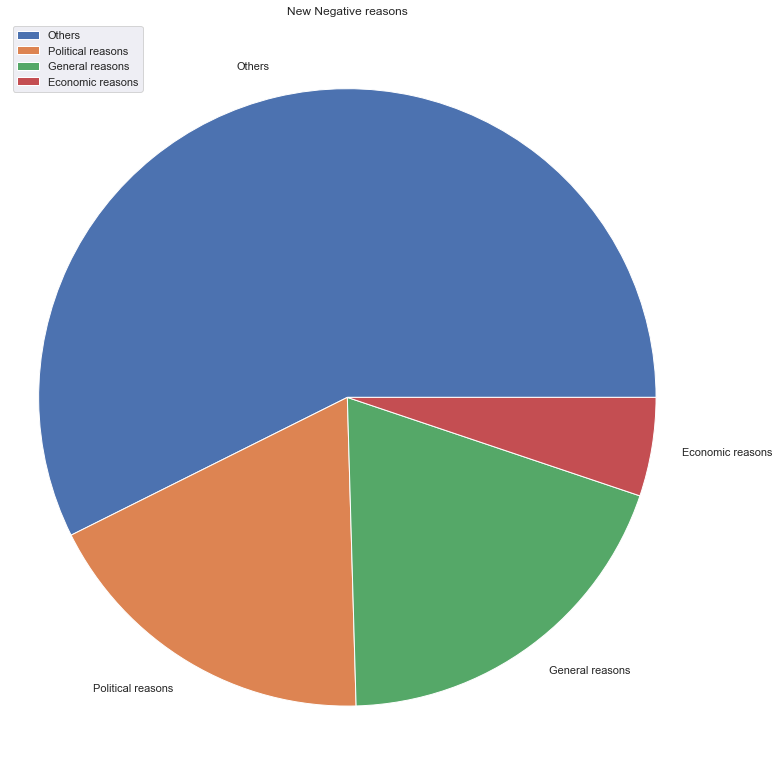

In [ ]:
# Find negative reasons
neg_reason_new = [word for word in Counter(election_negative['negative_reason']).keys()]
# Compute the count for each reason
neg_count_new = [Counter(election_negative['negative_reason'])[word] for word in Counter(election_negative['negative_reason']).keys()]

# Plot the pie chart for visualizing the negative reason for negative sentiment of election data
fig, ax = plt.subplots(figsize=[11, 11])
ax.pie(neg_count_new, labels = neg_reason_new)
ax.axis('equal')  
ax.set_title('New Negative reasons')
plt.legend(loc="upper left")
fig.tight_layout()
plt.show()

In [ ]:
# Creat a dataframe with columns true negative reason and its prediction for visulaization
elec_neg_test = pd.DataFrame()
elec_neg_test['True negative reason'] = y_test_neg
elec_neg_test['Predict negative reason'] = test_pred
elec_neg_test

,True negative reason,Predict negative reason
661,Political reasons,Political reasons
864,Others,Others
216,Others,Others
979,General reasons,Others
184,Others,Others
...,...,...
906,General reasons,Others
884,Political reasons,Others
994,Others,Others
247,Political reasons,Others


In [ ]:
# Extract the data that the true negative reason are economic reasons
elec_neg_test[elec_neg_test['True negative reason'] == 'Economic reasons']

,True negative reason,Predict negative reason
857,Economic reasons,Others
844,Economic reasons,General reasons
950,Economic reasons,Economic reasons
562,Economic reasons,Economic reasons
47,Economic reasons,Others
885,Economic reasons,Others


In [ ]:
# The detail of tweets 857
election_negative.loc[857]

text               joke wait till election remember spent 600 mil...
sentiment                                                          0
negative_reason                                     Economic reasons
party                                                            NaN
Name: 857, dtype: object

### C)

I used the frequency of the words for both positive and negative tweets using the ground truth sentiment to rank the top-50 most frequent non-stop-words in the Canadian elections dataset. The results shown below show that the top-5 most frequent words are similar for both positive and negative tweets, which shows the tweets are discussing similar topics. However, the negative tweets included more negative words, such as dont, never, cant, etc., whereas positive tweets have more positive words. Also, we can see some negative reasons in the top-50 most frequent for negative words, such as gun, call(election too early), etc.

In [ ]:
# Extract election data with positive sentiments
election_positive = election_copy.drop(['hashtag', 'mentions', 'withparty'], axis=1)[election_copy['sentiment'] == 'positive']

In [ ]:
# Define a function to return the most frequent words
def get_top_n_words(corpus, n = None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# Get the top-50 most frequent non-stop-words for the negative tweets in Canadian elections data
common_neg_words = get_top_n_words(election_negative['text'], 50)
for word, freq in common_neg_words:
    print(word, freq)

election 270
canadian 210
trudeau 144
otoole 110
canada 75
pandemic 51
vote 48
like 45
conservative 38
dont 35
liberal 33
year 32
party 32
gun 31
want 30
called 29
say 29
pm 26
people 26
care 26
leader 24
one 24
get 24
think 23
never 23
justin 23
call 22
million 22
win 21
would 21
calling 21
country 20
erin 20
day 20
he 20
cant 19
many 19
know 19
con 19
good 19
government 18
time 18
going 18
lie 18
right 17
unnecessary 17
bad 17
covid 16
plan 16
way 16


In [ ]:
# Get the top-50 most frequent non-stop-words for the negative tweets in Canadian elections data
common_pos_words = get_top_n_words(election_positive['text'], 50)
for word, freq in common_pos_words:
    print(word, freq)

election 407
canadian 312
vote 196
trudeau 171
otoole 136
canada 128
party 87
good 74
win 72
get 63
liberal 60
federal 59
conservative 56
like 54
freedom 50
day 50
want 46
need 45
leader 45
best 44
right 43
dont 42
people 42
support 40
im 40
time 39
would 38
better 38
great 36
voting 36
hope 36
let 35
justin 35
love 35
ppc 35
one 33
make 33
think 32
ndp 31
voted 30
go 30
please 27
debate 26
care 26
choice 26
going 24
government 24
cpc 24
pandemic 23
know 23
